## Verificação de Algoritmos

Neste notebook serao testadas tecnicas mais tradicionais para classificacao das mensagens. Testado um treinamento nao supervisionado usando o Spectral Clustering, e tambem um treinamento supervisionado usando alguns algoritmos classificadores.

In [16]:
import os
import sys

sys.path.append(f"{os.getcwd()}/../../")

In [17]:
import time
import random
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

from sklearn.metrics.pairwise import (
    cosine_similarity, 
    cosine_distances,
    laplacian_kernel, 
    euclidean_distances, 
    sigmoid_kernel, 
    chi2_kernel,
    polynomial_kernel,
    rbf_kernel
)
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, v_measure_score, silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.cluster import SpectralClustering

from processing.utils import CleanUp, RSLP_STEMMER, SNOWBALL_STEMMER, NLP_LEMMATIZER

%matplotlib inline

clean_up = CleanUp(stemmer=SNOWBALL_STEMMER)

In [18]:
df = pd.read_csv(f"{os.getcwd()}/../../../data/dataset.csv", sep="|")
df["x"] = df["comentario"].apply(lambda comment: clean_up.fit(str(comment)))
df["y"] = df["classificacao"].apply(lambda clasf: 0 if clasf == "negativo" else 1)
textos = df[["x", "y"]].to_numpy()

In [19]:
print(random.choice(textos))
print(len(textos))
# print(df[df['x'] == ''].index)
# print(df.loc[250])

['ache que tav com febr mas era calor mesm' 0]
2459


### Unsupervised Learning : Spectral Clustering

Baseado no paper de referência: [Opinion Mining on Twitter Data using Unsupervised Learning Technique](https://www.ijcaonline.org/archives/volume148/number12/unnisa-2016-ijca-911317.pdf)

In [20]:
start = time.time()

validacoes = []
for Vectorizer, Norm in [(CountVectorizer, StandardScaler), (CountVectorizer, None), (TfidfVectorizer, None)]:
    for ngram_range in [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (3, 3)]:
        vectorizer = Vectorizer(ngram_range=ngram_range)
        X = vectorizer.fit_transform(textos[:, 0])
        norm_name = None
        if Norm:
            norm_name = Norm.__name__
            X = Norm(with_mean=False).fit_transform(X)
        y = textos[:, 1].astype(np.int).ravel()

        for metric in (
            cosine_distances,
            euclidean_distances, 
            sigmoid_kernel, 
            polynomial_kernel,
            rbf_kernel,
            # Usam apenas 1 cpu para calcular... muito lento
            # laplacian_kernel, 
            # chi2_kernel,
        ):
            for assign_labels in ["discretize", "kmeans"]:
                clustering = SpectralClustering(
                    n_clusters=2,
                    eigen_solver="amg",
                    assign_labels=assign_labels,
                    affinity="precomputed_nearest_neighbors",
                    random_state=0,
                    n_jobs=-1
                ).fit(metric(X))

                pred = clustering.labels_
                acc = round(accuracy_score(pred, y) * 100, 2)
                f1 = round(f1_score(pred, y) * 100, 2)
            
                validacoes.append((
                    vectorizer.__class__.__name__,
                    norm_name,
                    ngram_range,
                    metric.__name__,
                    assign_labels,
                    acc,
                    f1,
                ))

print(time.time() - start)

96.95600008964539


In [21]:
columns = ["Vectorizer", "Scaler", "NGram", "Metric", "AssignLabels", "Acc Mean", "F1 Mean"]
df = pd.DataFrame(validacoes, columns=columns)
df = df.sort_values(by=["F1 Mean", "Acc Mean", "Vectorizer", "Metric"], ascending=False)
df.head(25)

,Vectorizer,Scaler,NGram,Metric,AssignLabels,Acc Mean,F1 Mean
69,CountVectorizer,None,"(1, 1)",rbf_kernel,kmeans,50.10,57.88
68,CountVectorizer,None,"(1, 1)",rbf_kernel,discretize,56.69,57.18
98,CountVectorizer,None,"(1, 4)",rbf_kernel,discretize,56.93,56.51
108,CountVectorizer,None,"(1, 5)",rbf_kernel,discretize,55.35,54.74
88,CountVectorizer,None,"(1, 3)",rbf_kernel,discretize,57.67,54.32
155,TfidfVectorizer,None,"(1, 4)",sigmoid_kernel,kmeans,47.30,54.14
159,TfidfVectorizer,None,"(1, 4)",rbf_kernel,kmeans,47.30,54.14
157,TfidfVectorizer,None,"(1, 4)",polynomial_kernel,kmeans,47.30,54.14
175,TfidfVectorizer,None,"(3, 3)",sigmoid_kernel,kmeans,49.13,54.06
115,CountVectorizer,None,"(3, 3)",sigmoid_kernel,kmeans,49.13,54.06


              precision    recall  f1-score   support

           0       0.56      0.73      0.63      1455
           1       0.29      0.16      0.21      1004

    accuracy                           0.50      2459
   macro avg       0.43      0.45      0.42      2459
weighted avg       0.45      0.50      0.46      2459



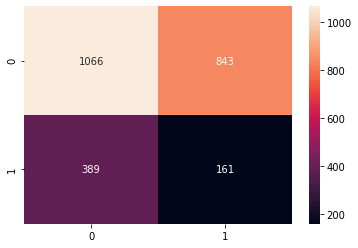

In [22]:
vectorizer = CountVectorizer(ngram_range=(1, 1))
X = vectorizer.fit_transform(textos[:, 0])
# X = StandardScaler(with_mean=False).fit_transform(X)
y = textos[:, 1].astype(np.int).ravel()

clustering = SpectralClustering(
    n_clusters=2,
    eigen_solver="amg",
    assign_labels="kmeans",
    affinity="precomputed_nearest_neighbors",
    random_state=0,
    n_jobs=-1
).fit(rbf_kernel(X))
pred = clustering.labels_

print(classification_report(y, pred))

df_cm = confusion_matrix(pred, y)
plt.figure(figsize=(6, 4))
sn.heatmap(df_cm, annot=True, fmt="d")
plt.show()

### Supervised Learning

Parcialmente baseado no paper: [Towards detecting influenza epidemics by analyzing Twitter messages](https://dl.acm.org/doi/pdf/10.1145/1964858.1964874)

In [29]:
start = time.time()

r_state = [0, 10, 50, 100, 1000]

classifiers = [
    ("LogisticRegression", LogisticRegression, {
        "max_iter":1000,
        "multi_class": "ovr",
        "n_jobs":-1
    }), 
    ("SGDClassifier", SGDClassifier, {
        "alpha": 1e-5,
        "n_jobs": -1,
        "max_iter": 5000,
        "n_iter_no_change": 100
    }), 
    ("SVC_Linear", SVC, {"kernel": "linear", "C": 5}),
    ("SVC_Linear_2", SVC, {"kernel": "linear"}),
    ("SVC_Linear_3", SVC, {"kernel": "linear", "C": 7}),
    ("SVC_RBF", SVC, {"gamma": 0.5, "C": 5}),
    ("SVC_RBF_2", SVC, {"gamma": 0.1, "C": 5}),
    ("SVC_RBF_3", SVC, {"gamma": 0.1, "C": 1}),
]

validacoes = []
for Vectorizer, Norm in [(CountVectorizer, StandardScaler), (CountVectorizer, None), (TfidfVectorizer, None)]:
    for ngram_range in [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (3, 3)]:
        vectorizer = Vectorizer(ngram_range=ngram_range)
        X = vectorizer.fit_transform(textos[:, 0])
        y = textos[:, 1].astype(np.int).ravel()
        
        norm_name = None
        if Norm:
            norm_name = Norm.__name__
            X = Norm(with_mean=False).fit_transform(X)

        for name, Classifier, params in classifiers:
            acc , f1 = [], []
            for i in range(5):
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=r_state[i])
                clf = Classifier(random_state=r_state[i], **params).fit(X_train, y_train)
                pred = clf.predict(X_test)
                acc.append(round(accuracy_score(pred, y_test) * 100, 2))
                f1.append(round(f1_score(pred, y_test) * 100, 2))
            acc, f1 = np.asarray(acc), np.asarray(f1)
            validacoes.append((
                vectorizer.__class__.__name__,
                r_state[i],
                norm_name,
                ngram_range,
                name,
                round(acc.mean(), 2),
                acc.max(),
                round(f1.mean(), 2),
                f1.max()
            ))

print(time.time() - start)

612.0406537055969


In [30]:
columns = ["Vectorizer", "RandomState", "Scaler", "NGram", "Classifier", "Acc Mean", "Acc Max.", "F1 Mean", "F1 Max."]
df = pd.DataFrame(validacoes, columns=columns)
df = df.sort_values(by=["Acc Max.", "F1 Max.", "Vectorizer", "NGram"], ascending=False)
df.head(25)

,Vectorizer,RandomState,Scaler,NGram,Classifier,Acc Mean,Acc Max.,F1 Mean,F1 Max.
105,TfidfVectorizer,1000,None,"(1, 2)",SGDClassifier,77.32,80.28,69.58,73.71
108,TfidfVectorizer,1000,None,"(1, 2)",SVC_Linear_3,76.91,80.28,69.54,73.71
106,TfidfVectorizer,1000,None,"(1, 2)",SVC_Linear,77.03,80.08,69.78,73.51
121,TfidfVectorizer,1000,None,"(1, 4)",SGDClassifier,77.40,79.47,67.84,70.74
114,TfidfVectorizer,1000,None,"(1, 3)",SVC_Linear,77.48,79.27,69.23,72.59
116,TfidfVectorizer,1000,None,"(1, 3)",SVC_Linear_3,77.40,79.27,69.08,72.59
109,TfidfVectorizer,1000,None,"(1, 2)",SVC_RBF,77.44,79.07,68.84,72.21
117,TfidfVectorizer,1000,None,"(1, 3)",SVC_RBF,77.56,78.86,67.75,72.04
122,TfidfVectorizer,1000,None,"(1, 4)",SVC_Linear,77.93,78.86,69.05,71.77
96,TfidfVectorizer,1000,None,"(1, 1)",LogisticRegression,76.58,78.86,66.60,70.65


Cross Validation accuracy: 0.75 (+/- 0.03)

              precision    recall  f1-score   support

           0       0.79      0.84      0.82       297
           1       0.73      0.67      0.70       195

    accuracy                           0.77       492
   macro avg       0.76      0.75      0.76       492
weighted avg       0.77      0.77      0.77       492



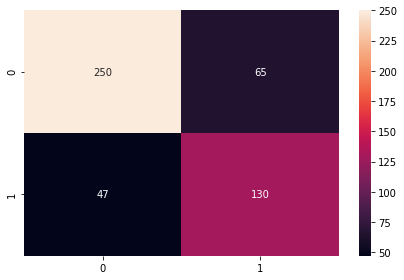

In [36]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
X = vectorizer.fit_transform(textos[:, 0])
y = textos[:, 1].astype(np.int).ravel()

r_state = 1000

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# clf = SGDClassifier(
#     alpha=1e-5,
#     random_state=0,
#     n_jobs=-1,
#     max_iter=5000,
#     n_iter_no_change=100
# ).fit(X_train, y_train)

clf = SVC(kernel="linear", C=5, random_state=r_state)
scores = cross_val_score(clf, X_train, y_train, cv=5)
print("Cross Validation accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print()

clf = SVC(kernel="linear", C=5, random_state=r_state).fit(X_train, y_train)
pred = clf.predict(X_test)

print(classification_report(y_test, pred))

df_cm = confusion_matrix(pred, y_test)
plt.figure(figsize=(6, 4))
sn.heatmap(df_cm, annot=True, fmt="d")
plt.tight_layout()
plt.show()

### Supervised Learning : Ensemble

Cross Validation accuracy: 0.72 (+/- 0.04)

              precision    recall  f1-score   support

           0       0.78      0.92      0.84       315
           1       0.79      0.53      0.63       177

    accuracy                           0.78       492
   macro avg       0.78      0.72      0.74       492
weighted avg       0.78      0.78      0.77       492



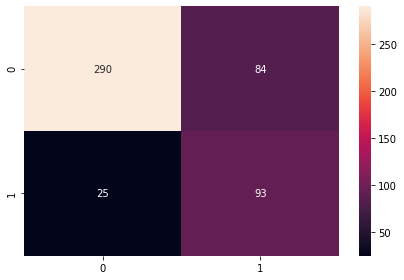

In [37]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3))
X = vectorizer.fit_transform(textos[:, 0])
# X = StandardScaler(with_mean=False).fit_transform(X)
y = textos[:, 1].astype(np.int).ravel()

r_state = 0

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf1 = LogisticRegression(random_state=r_state, n_jobs=-1, max_iter=1000, multi_class="ovr",)
clf2 = RandomForestClassifier(n_estimators=100, random_state=r_state)
clf3 = MultinomialNB()

eclf = VotingClassifier(
    estimators=[('lr', clf1), ('rf', clf2), ('mnb', clf3)],
    voting='soft', weights=[2, 2, 1], n_jobs=-1
)

scores = cross_val_score(eclf, X_train, y_train, cv=5)
print("Cross Validation accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print()

eclf = VotingClassifier(
    estimators=[('lr', clf1), ('rf', clf2), ('mnb', clf3)],
    voting='soft', weights=[2, 2, 1], n_jobs=-1
).fit(X_train, y_train)
pred = eclf.predict(X_test)

print(classification_report(y_test, pred))

df_cm = confusion_matrix(pred, y_test)
plt.figure(figsize=(6, 4))
sn.heatmap(df_cm, annot=True, fmt="d")
plt.tight_layout()
plt.show()